# XGBRegressor Evaluation

## read fold results and print as table

In [1]:
# load config file
import os
import yaml
import pandas as pd

config_path = os.path.join("..", "..", "Config", "XGB", "configs.yaml")

with open(config_path, 'r') as file:
    config = yaml.safe_load(file)
    
last_run_folder = config.get('last_run_folder', None)
output_folder = config.get('output_dir', None)

last_run_folder = os.path.join("..", "..", output_folder, last_run_folder)

# load results.csv
df = pd.read_csv(os.path.join(last_run_folder, "results.csv"))

# print the results sorted by rmse
df_sorted = df.sort_values(by='test_rmse')
print(df_sorted.to_string(index=False))

# read the median_params.yaml
median_params_path = os.path.join(last_run_folder, "median_params.yaml")
with open(median_params_path, 'r') as file:
    median_params = yaml.safe_load(file)
    
# print the median parameters
print("\nMedian Parameters:")
for key, value in median_params.items():
    print(f"{key}: {value}")

# print the median results
median_results = df_sorted.iloc[len(df_sorted) // 2]
print("\nMedian Results:")
for key, value in median_results.items():
    print(f"{key}: {value}")



 fold   train_rmse    test_rmse   train_mae     test_mae  train_r2  test_r2
    4 16923.328729  8538.187320 5350.941092  4017.068361  0.998826 0.999113
    5 17837.838932 13940.112201 5312.822417  5815.537215  0.998613 0.998761
    3 12431.218604 21527.730998 5905.682917 10982.403886  0.999351 0.996056
    2 17428.671147 39201.116143 5189.337596 10062.612230  0.998510 0.994164
    1 16953.975464 61048.920161 4324.735501 15947.349452  0.998171 0.990555

Median Parameters:
colsample_bytree: 0.895100074311251
learning_rate: 0.2702113506729492
max_depth: 2
n_estimators: 131
reg_alpha: 0.3059470293939967
reg_lambda: 0.8402106219103826
subsample: 0.9903791207778909

Median Results:
fold: 3.0
train_rmse: 12431.218603877058
test_rmse: 21527.730997769035
train_mae: 5905.682916802542
test_mae: 10982.403885723295
train_r2: 0.9993511789590132
test_r2: 0.9960563364743928


We select the median hyperparameter set, perform cross-validation on the dataset using these parameters, and save the resulting predictions.

## plot predictions

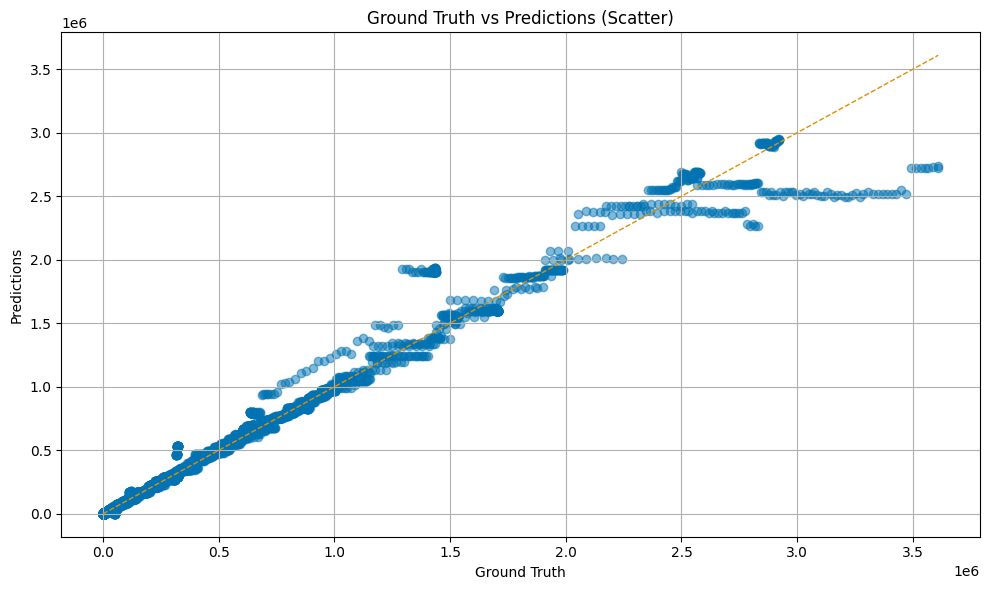

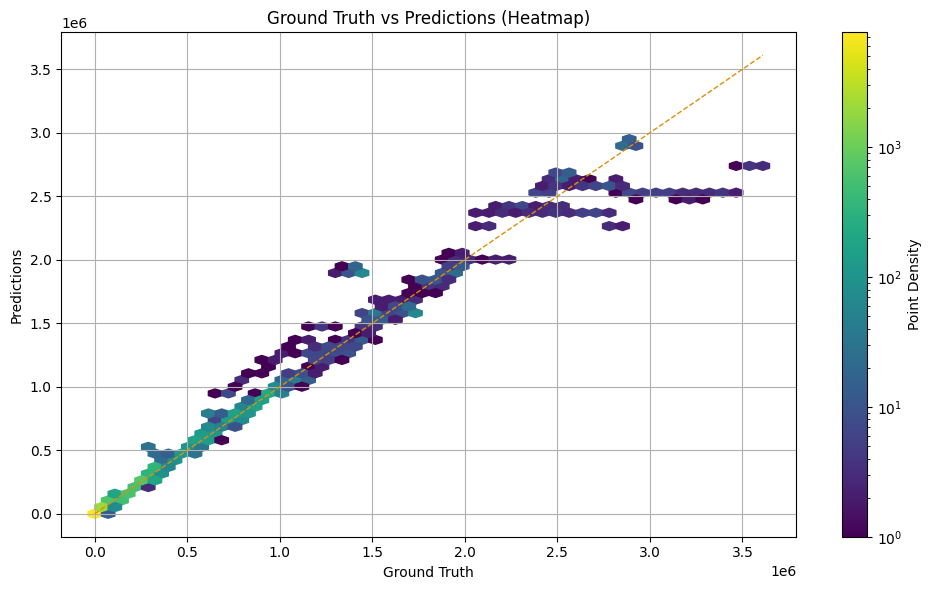

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

path_to_data = os.path.join(last_run_folder, "gt_vs_predictions.csv")

df = pd.read_csv(path_to_data)

# Use seaborn colorblind palette for scatter plot
palette = sns.color_palette("colorblind")
plt.figure(figsize=(10, 6))
plt.scatter(df["ground_truth"], df["predictions"], alpha=0.5, color=palette[0])
min_val = min(df["ground_truth"].min(), df["predictions"].min())
max_val = max(df["ground_truth"].max(), df["predictions"].max())
plt.plot([min_val, max_val], [min_val, max_val], color=palette[1], linestyle='--', linewidth=1)
plt.xlabel("Ground Truth")
plt.ylabel("Predictions")
plt.title("Ground Truth vs Predictions (Scatter)")
plt.grid(True)
plt.tight_layout()
plt.show()

# 2D Histogram (Heatmap) using a perceptually uniform, colorblind-friendly colormap
plt.figure(figsize=(10, 6))
hb = plt.hexbin(
    df["ground_truth"], df["predictions"],
    gridsize=50, cmap="viridis", bins='log'  # "viridis" is smooth and colorblind-friendly
)
plt.colorbar(hb, label='Point Density')
plt.plot([min_val, max_val], [min_val, max_val], color=palette[1], linestyle='--', linewidth=1)
plt.xlabel("Ground Truth")
plt.ylabel("Predictions")
plt.title("Ground Truth vs Predictions (Heatmap)")
plt.grid(True)
plt.tight_layout()
plt.show()

The low values have a good prediction but in the higher values the model isnt able to fit the data

## Calculate RMSE and R^2 over the whole data

In [3]:
from sklearn.metrics import root_mean_squared_error, r2_score

rmse = root_mean_squared_error(df["ground_truth"], df["predictions"])
mae = (df["ground_truth"] - df["predictions"]).abs().mean()
r2 = r2_score(df["ground_truth"], df["predictions"])

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R^2: {r2:.4f}")

RMSE: 59386.51
MAE: 15195.56
R^2: 0.9836


# Statistical analysis

In [4]:

# print percentage of gt = 0 from the whole dataset
percentage_gt_zero = (df["ground_truth"] == 0).mean() * 100
print(f"Percentage of ground truth values equal to 0: {percentage_gt_zero:.2f}%")

# mean and std of ground truth
mean_gt = df["ground_truth"].mean()
std_gt = df["ground_truth"].std()
print(f"Mean of ground truth: {mean_gt:.2f}")
print(f"Standard deviation of ground truth: {std_gt:.2f}")


Percentage of ground truth values equal to 0: 8.50%
Mean of ground truth: 251306.03
Standard deviation of ground truth: 464122.42


Although the MAE looks high at 15195.56, it’s actually quite reasonable when you consider the scale of the data. The average ground truth value is over 250,000.
This means that, compared to the typical values and the spread in the data, the average error is relatively small.

In [5]:
import statsmodels.api as sm

X = df['predictions']
y = df['ground_truth']

# Add intercept
X = sm.add_constant(X)

# Fit OLS model
model = sm.OLS(y, X).fit()

# Show summary including p-values
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           ground_truth   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                 1.045e+06
Date:                Tue, 03 Jun 2025   Prob (F-statistic):               0.00
Time:                        15:14:07   Log-Likelihood:            -2.1543e+05
No. Observations:               17360   AIC:                         4.309e+05
Df Residuals:                   17358   BIC:                         4.309e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1579.1193    513.692     -3.074      

The OLS regression shows that the XGB model’s predictions explain 98.4% of the variance in the ground truth (R² = 0.984), with a slope very close to 1 (0.997), indicating a strong linear relationship. The intercept is small but statistically significant. However, the residuals are skewed and autocorrelated, suggesting some patterns in the errors are not captured and there may be issues with the data distribution or model assumptions.


## Analyze errors

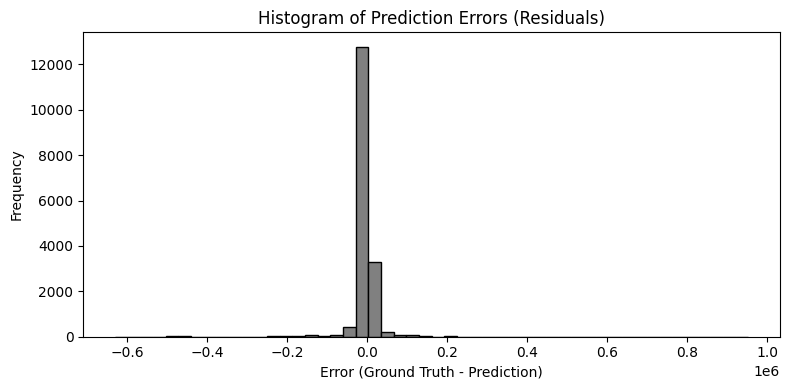

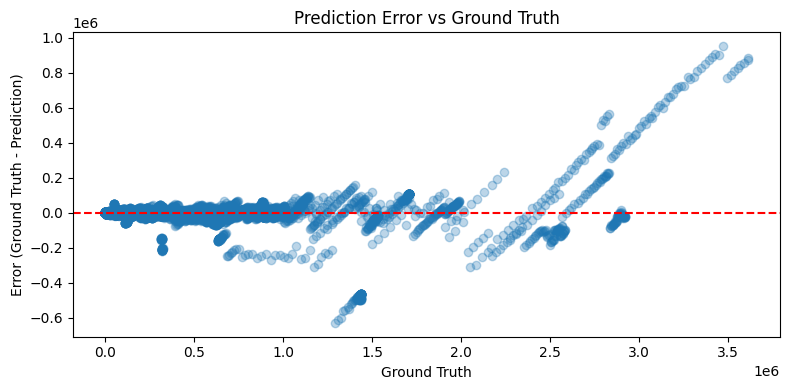

In [6]:
import numpy as np
# Calculate errors (residuals)
errors = df["ground_truth"] - df["predictions"]

# Plot histogram of errors
plt.figure(figsize=(8, 4))
plt.hist(errors, bins=50, color='gray', edgecolor='black')
plt.title("Histogram of Prediction Errors (Residuals)")
plt.xlabel("Error (Ground Truth - Prediction)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()
# Optional: Plot errors vs ground truth
plt.figure(figsize=(8, 4))
plt.scatter(df["ground_truth"], errors, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.title("Prediction Error vs Ground Truth")
plt.xlabel("Ground Truth")
plt.ylabel("Error (Ground Truth - Prediction)")
plt.tight_layout()
plt.show()

In the `Prediction Error vs Ground Truth` plot we can see the lines at the higher values.
This is clearly caused by the low complexity of the model that is not able to capture the underlying distribution.

## Limitations

Tree based models fit socioeconomical data.
Meaning using this model to forecast positive cases in countries or states where the socioeconomical status is significantly different may cause high errors, caused by the way the model works.
At each decision the model checks to see if a certain feature is higher or lower than a certain value, so for example if all the socioeconomical features a higher than all of the states this model was fitted, it will produce the same regression function

## SHAP

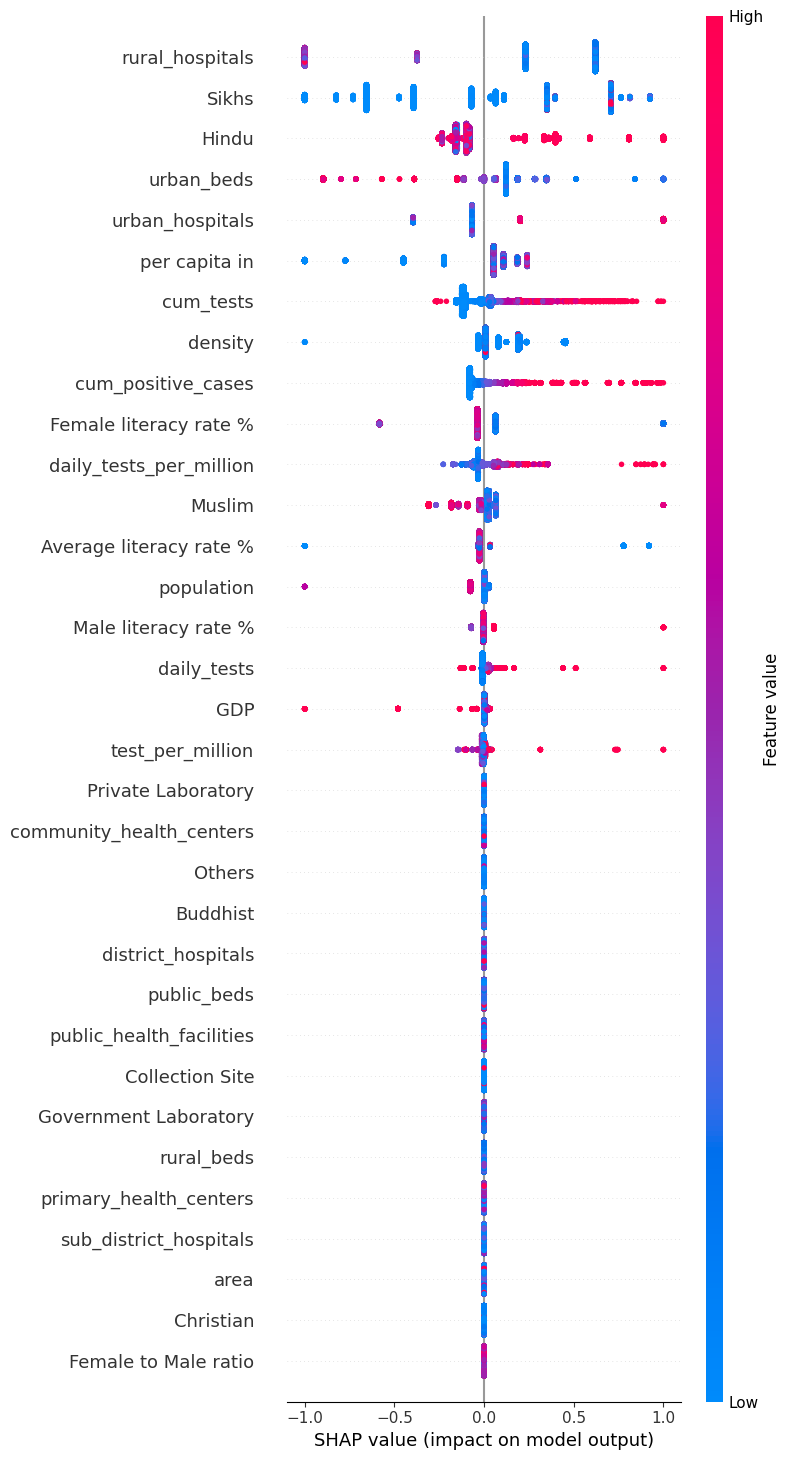

In [7]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
import shap
from xgboost import XGBRegressor
import numpy as np
import pandas as pd
import os

train_data = pd.read_csv(os.path.join("..", "..", config.get('data_path')))
X = train_data.drop(columns=['target', 'dates', 'state'])
y = train_data['target']

# Recreate and fit the model with the median parameters
model = XGBRegressor(**median_params)
model.fit(X, y)

# Create SHAP explainer and calculate SHAP values
explainer = shap.Explainer(model)
shap_values = explainer(X, check_additivity=False)  # <-- disable additivity check

shap_vals = shap_values.values
# Normalize each feature's SHAP values by its max absolute value
shap_vals_norm = shap_vals / (np.abs(shap_vals).max(axis=0)+ 1e-10)
shap.summary_plot(shap_vals_norm, X, feature_names=X.columns, max_display=X.shape[1])


Each feature is normalized by its own values in order to see the significance without one feature dominating the scale.
We get some mixed results yet we do have a few datapoints that show:
- More `urban beds` correlate to less sick people and vice versa
- Hgiher `GDP` is connected to less sick people 